### Import Libraries

In [1]:
# Ignore cuDDa warning messages
import warnings
import os
warnings.filterwarnings('ignore')

# Enable GPU
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

# # Expands the Jupyter Notebook Output Size to fit your window
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

# Load in tensorboard
%load_ext tensorboard

# Change the working directory back to the original to keep paths the same between files
os.chdir(r'C:\Users\Maxwell\PycharmProjects\TAMU-ECEN-403-IFPTSND\ECEN_403_IFM\TAMU-ECEN-403-IFPTSND')

import datetime
import pickle
import sys
from os.path import join, isfile
import shutil

import numpy as np
import pandas as pd
import tensorflow as tf

from tensorflow import keras
import tensorflow.keras.backend as kb
from tensorflow.python.ops import math_ops
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras import Sequential

from explore_entities import Graph_Entities
import ipywidgets as widgets
from ipywidgets import Layout, GridBox
from IPython.display import display
import matplotlib.pyplot as plt

import warnings
import os
import math
import json

from sklearn.metrics import mean_squared_error

warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

### Allows for scrolling windows to be very large

In [2]:
%%javascript
    IPython.OutputArea.auto_scroll_threshold = 9999

<IPython.core.display.Javascript object>

### Import TF_models and truncate the entities to only contain 880 companies

In [3]:
from tensorflow_models import TF_Models, Ein_Multiply, leaky_relu, rank_loss_func
DMJ = TF_Models('./ignorable_data/data_sets/NASDAQ_Cleaned - Contains ZUMZ/', './ignorable_data/models/[55, 25, 20]_split/', reload=False)
data_splits = DMJ.split_data()

DMJ.Normalized_Adjacency_Matrix = DMJ.Normalized_Adjacency_Matrix[0:880, 0:880]
DMJ.XX_tf = DMJ.XX_tf[0:-1, :, :]
DMJ.YY_tf = DMJ.YY_tf[0:-1, :]
DMJ.RR_tf = DMJ.RR_tf[0:-1, :]
DMJ.entities = DMJ.entities[0:-1]
DMJ.entities_idx.pop('ZUMZ')

model = DMJ.generate_model()

from graph_predictions import Graph_Predictions
GP = Graph_Predictions("./ignorable_data/models/[55, 25, 20]_split/", "./ignorable_data/strategies/RL_validation_strategies/", 'x_val', DMJ)

GridBox(children=(Dropdown(description='Model Types:', options=('lstm', 'lstm_gcn_1', 'lstm_gcn_2', 'lstm_gcn_…

### Split the training data

In [ ]:
# Given a total and list of splits, evenly distributes the total amount proportional to the given list
def split_windows(total, percentages_list):
    # Get a sum of the initial total
    percentage_sum = sum(percentages_list)

    # Create a new list based on a percentage of the total
    new_splits = []
    for perc in percentages_list:
        new_splits.append(int(total * (perc / percentage_sum)))
    
    # Where to shift the extra days that don't exactly divide between the values
    if sum(new_splits) != total:
        new_splits[-1] = new_splits[-1] + (total - sum(new_splits))

    return new_splits

one_x = DMJ.XX_tf
one_y = DMJ.YY_tf

time_split = [90, 710, 239, 199]
time_split = [55, 25, 20]

time_split = [40,40,20]
x_train, x_val, x_test = tf.split(one_x, split_windows(one_x.shape[1], time_split),
                                  axis=1)
y_train, y_val, y_test = tf.split(one_y, split_windows(one_y.shape[1], time_split),
                                  axis=1)
rr_train, rr_val, rr_test = tf.split(DMJ.RR_tf, split_windows(one_y.shape[1], time_split),
                                     axis=1)

SMALL_SIZE = 8
MEDIUM_SIZE = 20
BIGGER_SIZE = 12

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

## Bar Chart

In [ ]:
# import matplotlib
# import matplotlib.pyplot as plt
# %matplotlib inline
plt.style.use('seaborn')

datablock_dir = r'C:/Users/Maxwell/PycharmProjects/TAMU-ECEN-403-IFPTSND/ECEN_403_IFM/TAMU-ECEN-403-IFPTSND/ignorable_data/datablocks/[55, 25, 20]_splits'

datablock = [r'04-01-21-0AlphaLSTM-GooCol-3DRL-NoDropout-85Ep-10BS495win_495past_495fut_DATABLOCK',
             r'04-01-21-1AlphaLSTM-GooCol-3DRL-NoDropout-85Ep-10BS249win_249past_495fut_DATABLOCK',
             r'04-01-21-10AlphaLSTM-GooCol-3DRL-NoDropout-85Ep-10BS495win_495past_495fut_DATABLOCK',
             r'04-01-21-100AlphaLSTM-GooCol-3DRL-NoDropout-85Ep-10BS495win_495past_495fut_DATABLOCK',
             r'04-01-21-1000AlphaLSTM-GooCol-3DRL-NoDropout-85Ep-10BS495win_495past_495fut_DATABLOCK',
             r'04-01-21-10000AlphaLSTM-GooCol-3DRL-NoDropout-85Ep-10BS249win_249past_495fut_DATABLOCK',
             r'04-01-21-20000AlphaLSTM-GooCol-3DRL-NoDropout-85Ep-10BS495win_495past_495fut_DATABLOCK']

y = []
for d in datablock:
    obj = json.load(open(f'{datablock_dir}/{d}.json', 'r'))
    y.append(obj['Discontinuous_Cumulative_Return_Ratio'])
y = [i-1 for i in y]
x = ['0', '1', '10', '100', '1000', '10000', '20000']

x_pos = [i for i, _ in enumerate(x)]

fig, ax1 = plt.subplots()

fig.set_size_inches(11,5)
fig.set_dpi(100)

ax1.bar(x_pos, y, color='#ff4f4f')
ax1.set_ylabel("IRR")
ax1.set_xlabel("Alpha")

ax1.set_xticklabels(x, rotation=0)
ax1.set_xticks(x_pos)

ax1.tick_params(labelsize=10)
ax1.set(facecolor='white')
ax1.grid(color='#ebebeb')

for item in ([ax1.title, ax1.xaxis.label, ax1.yaxis.label]):
    item.set_fontsize(14)
    
for i, value in enumerate(y):
    plt.text(x_pos[i], value, " {:.2E}".format(value), rotation=45, fontsize=10, fontweight=550)
# plt.gca().invert_yaxis()
plt.show()

In [4]:
# !{sys.executable} -m pip install plotly

import explore_entities
# Load in the code
GE = Graph_Entities('./ignorable_data/data_sets/NASDAQ_Cleaned - Contains ZUMZ - Yuning/')
# Generate the baseline components we're wokring with
NAM, Adj, Rel = GE.get_matrix_components()

GridBox(children=(Text(value='Loading Normalized Adjacency Matrix:', disabled=True, layout=Layout(width='auto'…

GridBox(children=(Text(value='Loading Normalized Adjacency Matrix:', disabled=True, layout=Layout(width='auto'…

In [5]:
path = r'G:\Shared drives\Max Huffman - ECEN 403 404 URS Research 2020 2021\Datasets\weight_matrix\learned_implict_1_layer'

files = os.listdir(path)
files = ['/' + i for i in files if i != '.ipynb_checkpoints']
print(files)

# Get the first one
company_strengths = np.load(path + files[0])
# For all but the first, add the dimensions
for f in files[1:]:
    temp = np.load(path + f)
    company_strengths = np.concatenate([company_strengths, temp], axis=1)

['/test9.npy', '/test18.npy', '/test27.npy', '/test36.npy', '/test45.npy', '/test54.npy', '/test63.npy', '/test72.npy', '/test81.npy', '/test90.npy', '/test99.npy', '/test108.npy', '/test117.npy', '/test126.npy', '/test135.npy', '/test144.npy', '/testLAST.npy']


In [132]:
def reduced_matrix(adj,l):
    new_matrix = np.empty((l.shape[0], l.shape[0]))
    for idx, i in enumerate(l):
        for idy, j in enumerate(l):
            new_matrix[idx,idy] = adj[i, j]
    return new_matrix

[[1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]]
#
[[1. 0.]
 [0. 1.]]


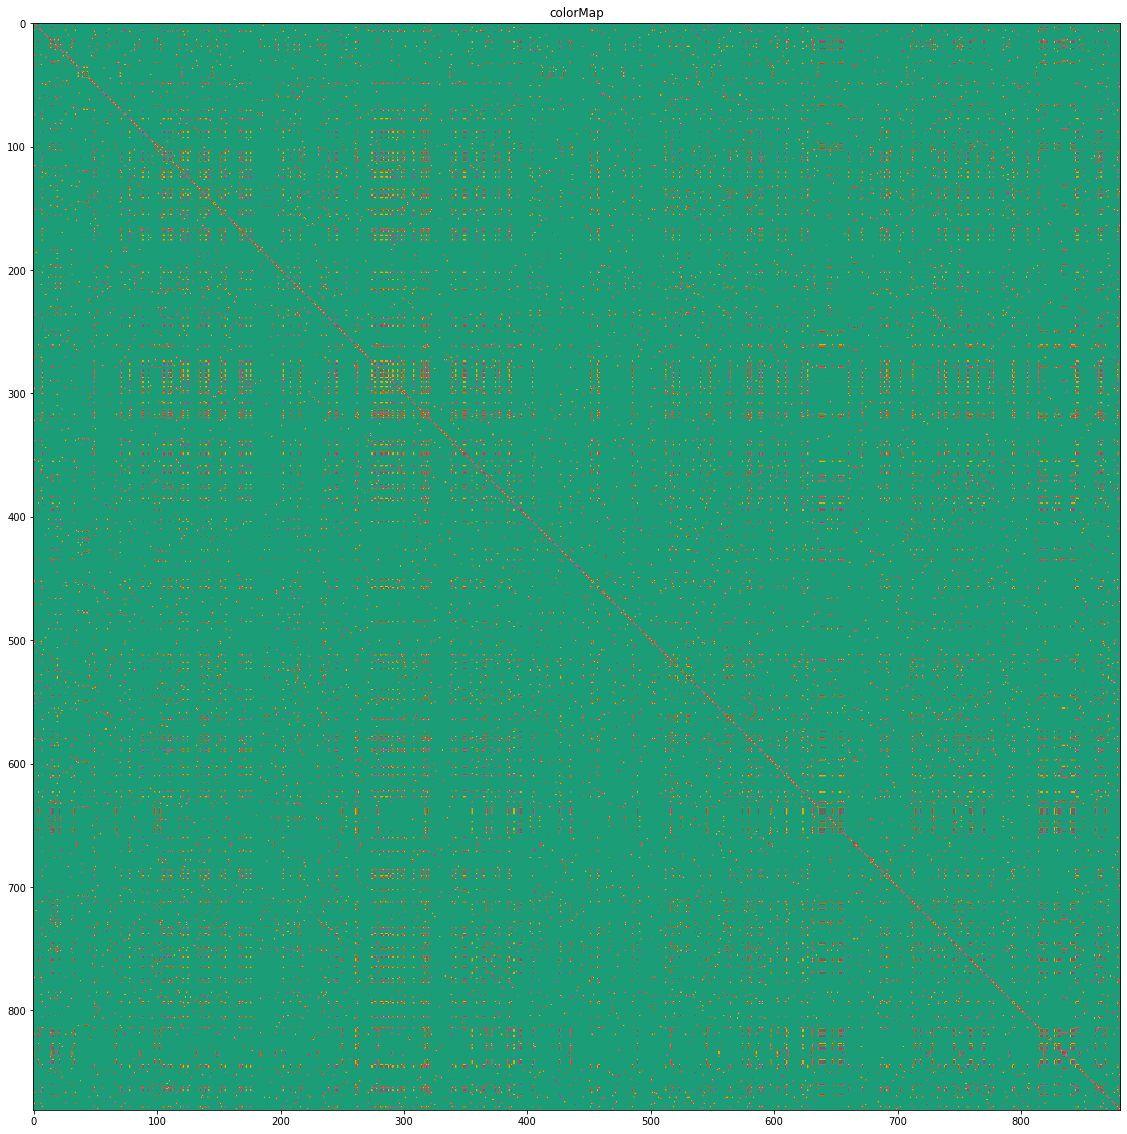

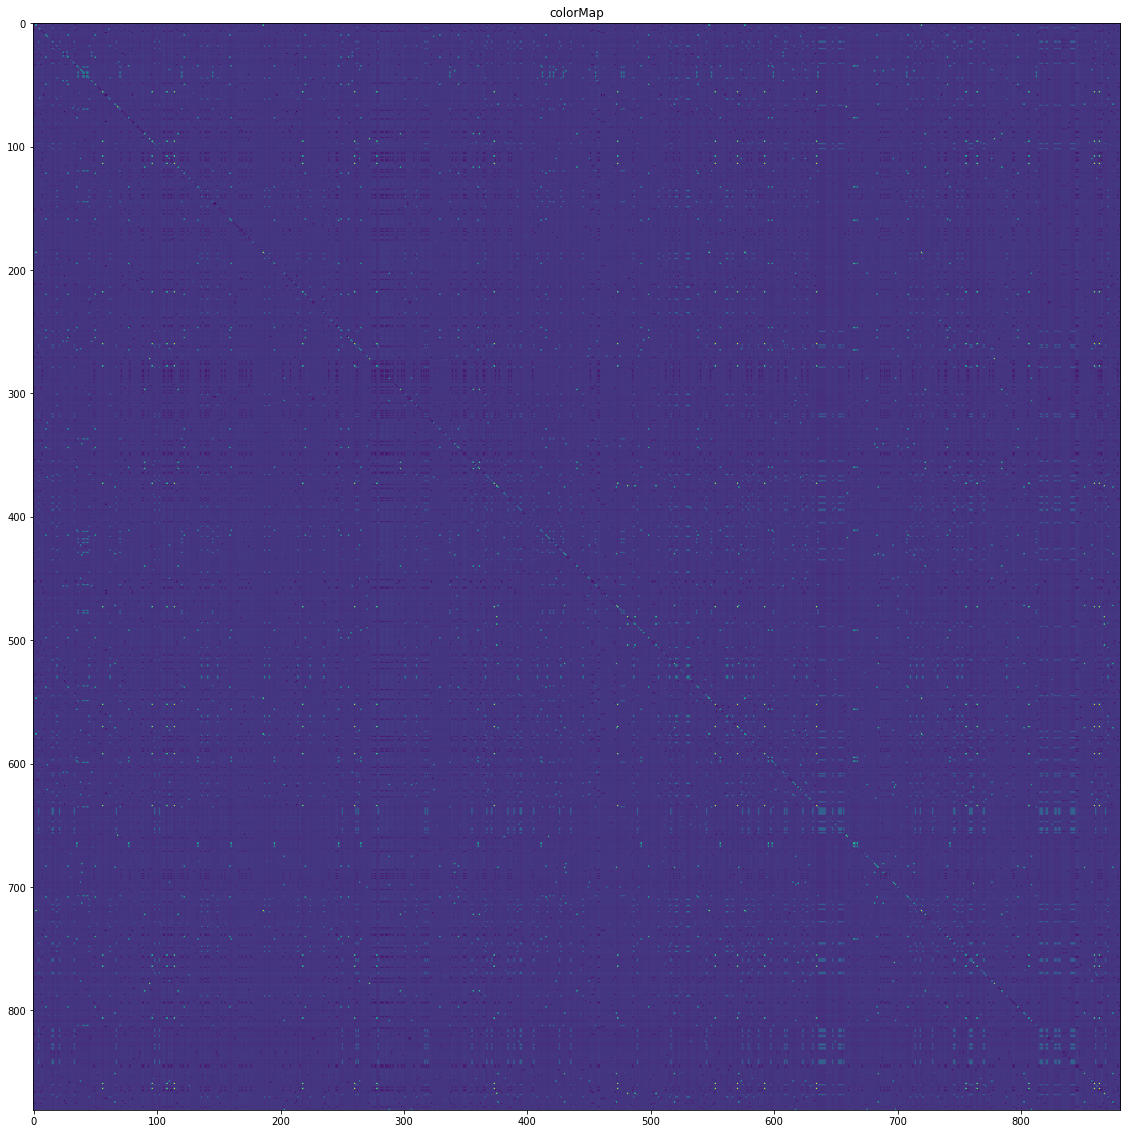

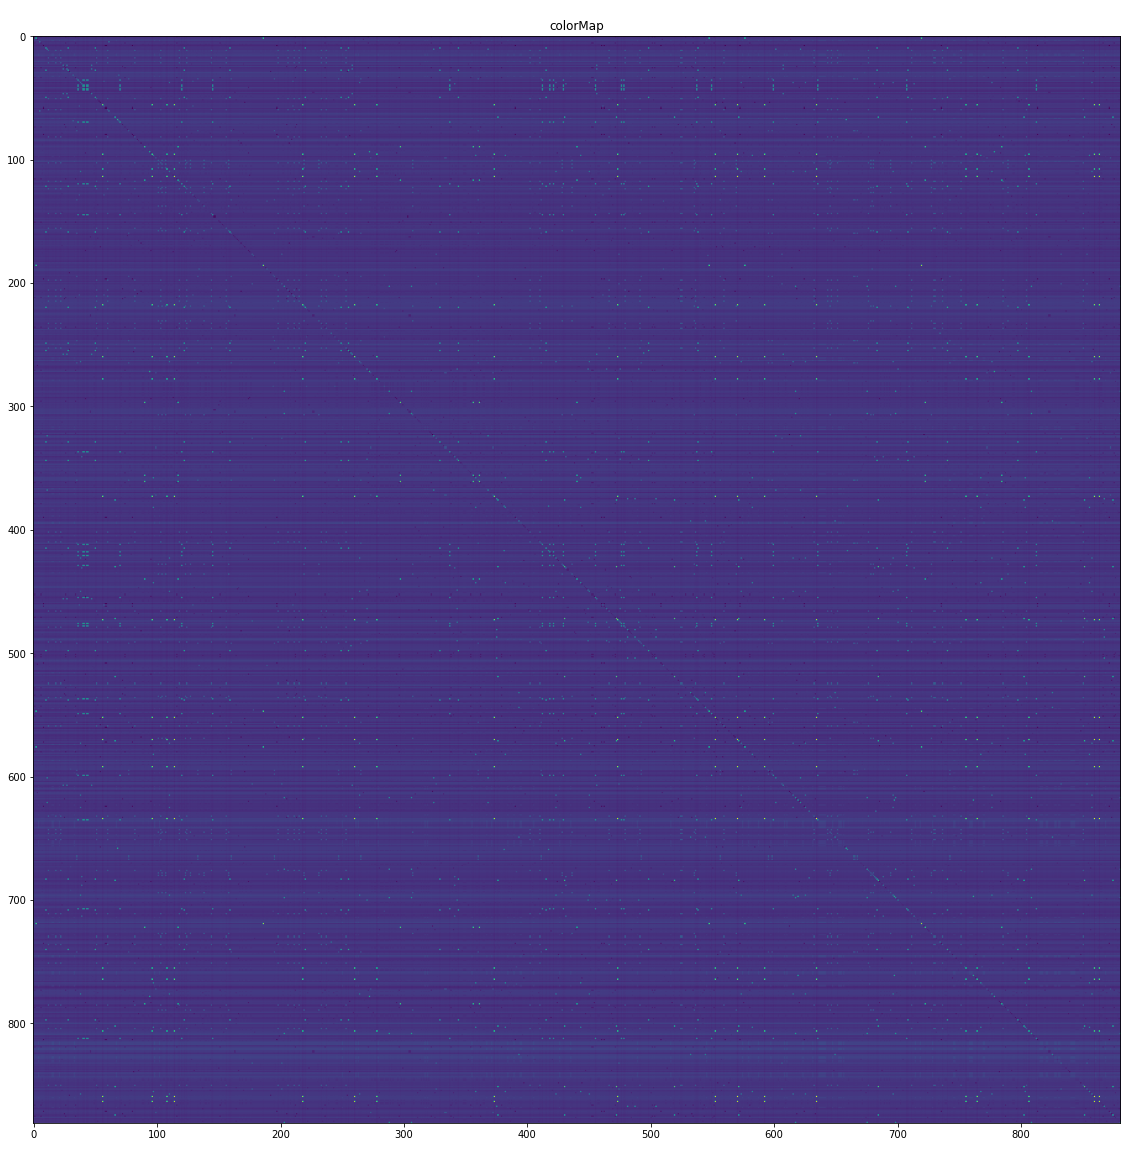

In [7]:
# plt.imshow(Adj, interpolation='none')
# plt.show()

# plt.imshow(company_strengths[:, 0, :], interpolation='none')
# plt.show()

size = (20,20)

fig = plt.figure(figsize=size)

ax = fig.add_subplot(111)
ax.set_title('colorMap')
plt.imshow(Adj, cmap='Dark2')
ax.set_aspect('equal')
plt.show()

fig = plt.figure(figsize=size)

ax = fig.add_subplot(111)
ax.set_title('colorMap')
plt.imshow(company_strengths[:, 0, :])
ax.set_aspect('equal')
plt.show()

fig = plt.figure(figsize=size)

ax = fig.add_subplot(111)
ax.set_title('colorMap')
plt.imshow(company_strengths[:, -1, :])
ax.set_aspect('equal')

cax = fig.add_axes([0.12, 0.1, 0.78, 0.8])
cax.get_xaxis().set_visible(False)
cax.get_yaxis().set_visible(False)
cax.patch.set_alpha(0)
cax.set_frame_on(False)
cax.grid(b=None)
# plt.colorbar(orientation='vertical')
plt.show()

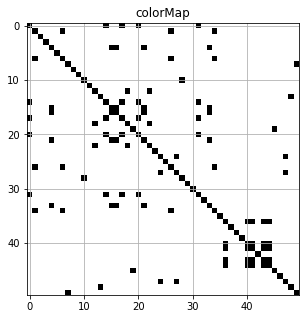

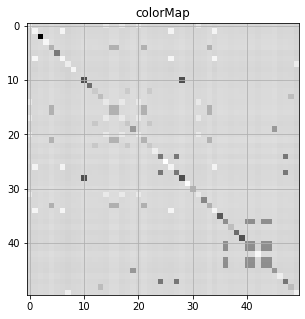

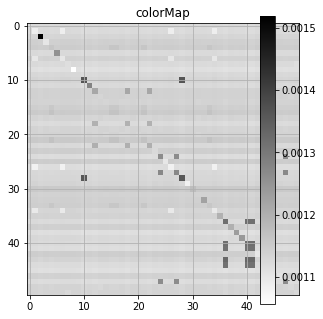

In [23]:
# plt.imshow(Adj, interpolation='none')
# plt.show()

# plt.imshow(company_strengths[:, 0, :], interpolation='none')
# plt.show()

size = (5,5)
cax.grid(b=None)
fig = plt.figure(figsize=size)

ax = fig.add_subplot(111)
ax.set_title('colorMap')
plt.imshow(Adj[0:50, 0:50], cmap='binary')
ax.set_aspect('equal')
plt.grid(b=None)
plt.show()

fig = plt.figure(figsize=size)

ax = fig.add_subplot(111)
ax.set_title('colorMap')
plt.imshow(company_strengths[0:50, 0, 0:50], cmap='binary')
ax.set_aspect('equal')
plt.grid(b=None)
plt.show()

fig = plt.figure(figsize=size)

ax = fig.add_subplot(111)
ax.set_title('colorMap')
plt.grid(b=None)
bottom = plt.imshow(company_strengths[0:50, -1, 0:50], cmap='binary')
ax.set_aspect('equal')

cax = fig.add_axes([0.12, 0.1, 0.78, 0.8])
cax.get_xaxis().set_visible(False)
cax.get_yaxis().set_visible(False)
cax.patch.set_alpha(0)
cax.set_frame_on(False)

plt.colorbar(orientation='vertical')
plt.show()

plt.show()

In [148]:
np.concatenate([np.array([i[0] for i in DMJ.relations_dict['EDP Services']]), np.array([i[0] for i in DMJ.relations_dict['Business Services']])])

array([290, 434, 835, 833,   0,  86, 750, 726, 837,  20, 148, 655, 818,
       555, 753, 230, 630,  31, 132, 847, 611, 723, 602, 184,  14, 834,
       196, 204,  17, 585, 604, 790, 742, 133, 667, 160, 556, 665, 492,
        35, 664, 265, 360, 595, 247, 598,  77, 195, 411])

In [218]:
Rel.shape
np.sum(Rel, 0)

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)

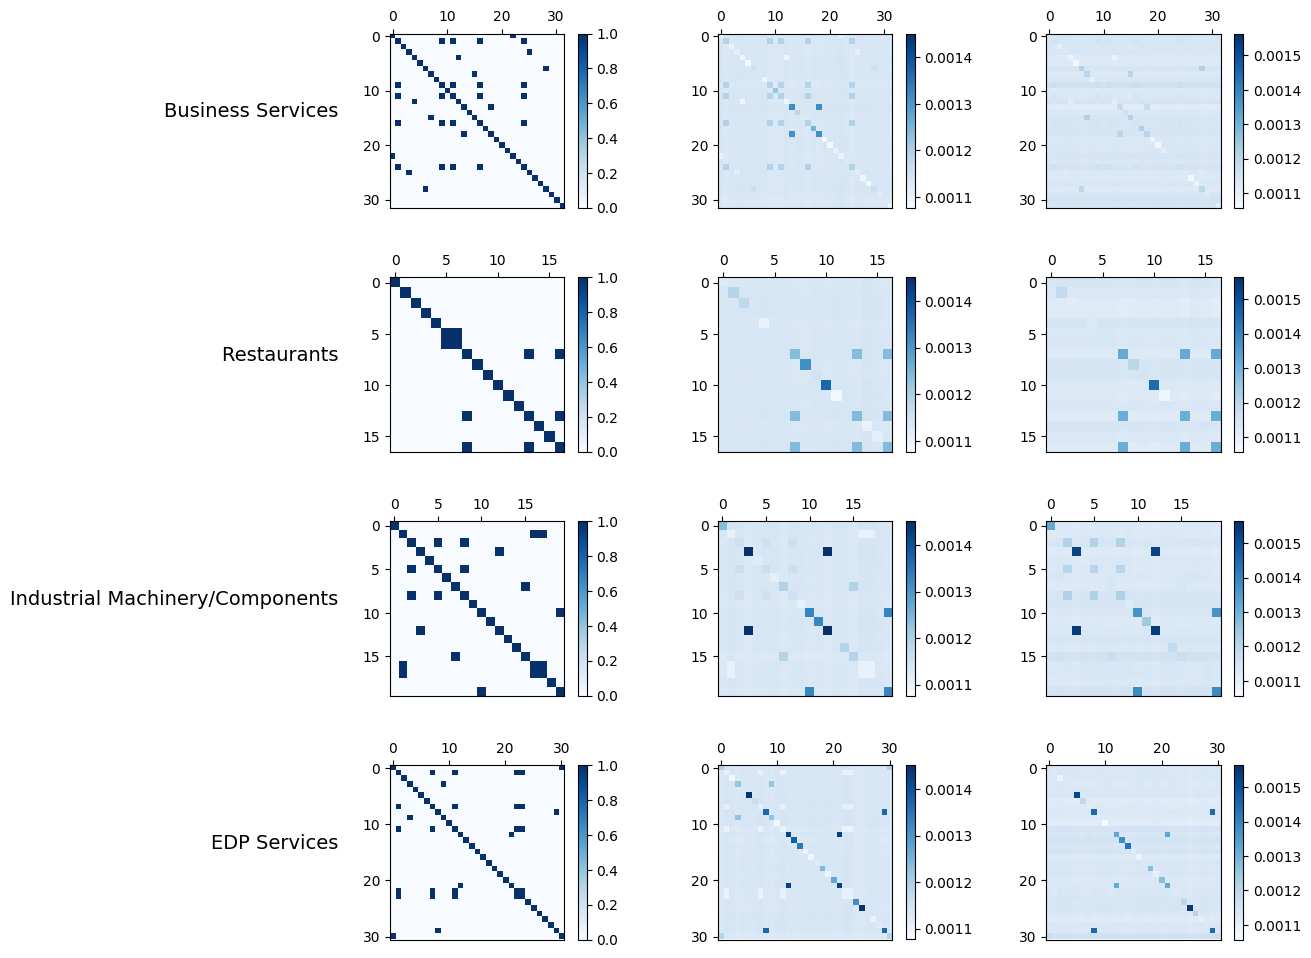

In [220]:
# Import packages necessary to create colorbar
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.ticker import MaxNLocator

def reduced_matrix(adj,l):
    new_matrix = np.empty((l.shape[0], l.shape[0]))
    for idx, i in enumerate(l):
        for idy, j in enumerate(l):
            new_matrix[idx,idy] = adj[i, j]
    return new_matrix


def show_weight_matrices(n_row, n_columns, row_titles, column_titles, DMJ, Adj, init_weight, post_weight):

    fig, ax = plt.subplots(n_row,n_columns, figsize=(n_row*n_columns,n_row*n_columns), dpi=100)
    fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.4)
    for i in range(n_row):
        
        relation_indices = np.array([i[0]+1 for i in DMJ.relations_dict[column_titles[i-1]]])
        mat = [reduced_matrix(Adj, relation_indices), reduced_matrix(init_weight, relation_indices), reduced_matrix(post_weight, relation_indices)]
        min_v = [np.min(Adj), np.min(init_weight), np.min(post_weight)]
        max_v = [np.max(Adj), np.max(init_weight), np.max(post_weight)]
        
        for j in range(n_columns):
            
            im = ax[i,j].imshow(mat[j], cmap='Blues', vmin=min_v[j], vmax=max_v[j])
#             ax[i,j].set_xlabel('Companies')
            
            ax[i,j].xaxis.tick_top()
#             ax[i,j].xaxis.set_visible(False)
#             ax[i,j].yaxis.set_visible(False)
#             ax[i,j].xaxis.set_major_locator(MaxNLocator(integer=True))
#             ax[i,j].yaxis.set_major_locator(MaxNLocator(integer=True))
            fig.colorbar(im, ax=ax[i, j])
#         ax[0,i-1].set_title(row_titles[i-1], fontsize=14)
        ax[i-1,0].set_ylabel(column_titles[i-1] + ' '*3, rotation=0, fontsize=14, horizontalalignment='right')
    plt.show()


show_weight_matrices(4, 3, ["Original Relationships", "Weight Initialization", "Post-Training" ],
                     ['Business Services', 'Restaurants', 'Industrial Machinery/Components', 'EDP Services'],
                     DMJ, Adj, company_strengths[:, 0, :], company_strengths[:, -1, :])

In [ ]:
def scatter_relationships(ax1, adj):
    for idx, x in enumerate(adj):
        for iny, y in enumerate(x):
            ax1.scatter(idx, iny, color='black')

scatter_relationships(ax1, small_Adj)

    

datablock_dir = r'C:/Users/Maxwell/PycharmProjects/TAMU-ECEN-403-IFPTSND/ECEN_403_IFM/TAMU-ECEN-403-IFPTSND/ignorable_data/datablocks/[55, 25, 20]_splits'

datablock = r'04-03-21-10Alpha88BsLSTM-GooCol-3DRL-100Ep-3DEXPLICIT495win_495past_249fut_DATABLOCK_1AVG'
obj = json.load(open(f'{datablock_dir}/{datablock}.json', 'r'))
y1 = obj['Discontinuous_Investment_Value_List']
e1 = obj['Entity_Choices']


datablock = r'04-03-21-10Alpha88BsLSTM-GooCol-3DRL-200Ep-3DIMPLICIT495win_495past_249fut_DATABLOCK_1AVG'
obj = json.load(open(f'{datablock_dir}/{datablock}.json', 'r'))
y2 = obj['Discontinuous_Investment_Value_List']
e2 = obj['Entity_Choices']

datablock = r'0 - Test AVG'
obj = json.load(open(f'{datablock_dir}/{datablock}.json', 'r'))
y3 = obj['Discontinuous_Investment_Value_List']

x = range(0, x_test.shape[1]-2)

fig, ax1 = plt.subplots()
ax1.set_xlim([0,x_test.shape[1]-3])

fig.set_size_inches(7,7)
fig.set_dpi(100)
fig.frameon=True

# Graph the predictions
# ax1.plot(x, y1, color='#db00c2', label='Explicit Model')
# ax1.plot(x, y2, color='#00db7d', label='Implicit Model')


graph_same_choice(ax1, e1, e2, y1, y2)

# Graph the average
# ax1.plot(x, y3, color='black', label='Average Model', linewidth=2.5)

# ax1.set_title("Implict Model on Testing Set")
ax1.set_ylabel("Entities")
ax1.set_xlabel("Entities")

ax1.set_xticks(np.arange(0, x_test.shape[1]-3, 20))
ax1.legend(prop={'size': 12})
ax1.legend(bbox_to_anchor=(1.01, 1), loc='upper left')


ax1.tick_params(labelsize=10)
ax1.set(facecolor='white')
ax1.grid(color='#ebebeb')
# plt.gca().set_aspect("equal")

for item in ([ax1.title, ax1.xaxis.label, ax1.yaxis.label]):
    item.set_fontsize(14)
    
for item in (ax1.get_xticklabels() + ax1.get_yticklabels()):
    item.set_fontsize(12)

plt.show()

In [ ]:
datablock_dir = r'C:/Users/Maxwell/PycharmProjects/TAMU-ECEN-403-IFPTSND/ECEN_403_IFM/TAMU-ECEN-403-IFPTSND/ignorable_data/datablocks/[55, 25, 20]_splits'

datablock = r'04-08-21-10Alpha22BsLSTM-GooCol-3DRL-150Ep-3DEXPLICIT_EXTENDED495win_495past_249fut_DATABLOCK_16AVG'
obj = json.load(open(f'{datablock_dir}/{datablock}.json', 'r'))
y1 = obj['Discontinuous_Investment_Value_List']


datablock = r'04-08-21-10Alpha22BsLSTM-GooCol-3DRL-150Ep-3DEXPLICIT_EXTENDED495win_495past_249fut_DATABLOCK_1AVG'
obj = json.load(open(f'{datablock_dir}/{datablock}.json', 'r'))
y2 = obj['Discontinuous_Investment_Value_List']

datablock = r'04-08-21-10Alpha22BsLSTM-GooCol-3DRL-150Ep-3DEXPLICIT_EXTENDED495win_495past_249fut_DATABLOCK_4AVG'
obj = json.load(open(f'{datablock_dir}/{datablock}.json', 'r'))
y3 = obj['Discontinuous_Investment_Value_List']
#########################################################################################################################
datablock = r'04-08-21-10Alpha22BsLSTM-GooCol-3DRL-150Ep-3DEXPLICIT_EXTENDED495win_495past_249fut_DATABLOCK_44AVG'
obj = json.load(open(f'{datablock_dir}/{datablock}.json', 'r'))
y4 = obj['Discontinuous_Investment_Value_List']

datablock = r'04-08-21-10Alpha22BsLSTM-GooCol-3DRL-150Ep-3DEXPLICIT_EXTENDED495win_495past_249fut_DATABLOCK_8AVG'
obj = json.load(open(f'{datablock_dir}/{datablock}.json', 'r'))
y5 = obj['Discontinuous_Investment_Value_List']

datablock = r'04-08-21-10Alpha22BsLSTM-GooCol-3DRL-150Ep-3DEXPLICIT_EXTENDED495win_495past_249fut_DATABLOCK_220AVG'
obj = json.load(open(f'{datablock_dir}/{datablock}.json', 'r'))
y6 = obj['Discontinuous_Investment_Value_List']

datablock = r'0 - Test AVG'
obj = json.load(open(f'{datablock_dir}/{datablock}.json', 'r'))
y7 = obj['Discontinuous_Investment_Value_List']


x = range(0, x_test.shape[1]-2)

fig, ax1 = plt.subplots()
ax1.set_xlim([0,x_test.shape[1]-3])

fig.set_size_inches(10,6)
fig.set_dpi(100)
fig.frameon=True

# Graph the predictions
ax1.plot(x, y2, label='Explicit+ Model - Top 1')
ax1.plot(x, y3, label='Explicit+ Model - Top 4')
ax1.plot(x, y5, label='Explicit+ Model - Top 8')
ax1.plot(x, y1, label='Explicit+ Model - Top 16')
ax1.plot(x, y4, label='Explicit+ Model - Top 44')
ax1.plot(x, y6, label='Explicit+ Model - Top 220')


# Graph the average
ax1.plot(x, y7, color='black', label='Average Model', linewidth=2.5)

# ax1.set_title("Implict Model on Testing Set")
ax1.set_ylabel("Dollars (USD)")
ax1.set_xlabel("Time (Trading Days)")

ax1.set_xticks(np.arange(0, x_test.shape[1]-3, 20))
ax1.legend(prop={'size': 12})


ax1.tick_params(labelsize=10)
ax1.set(facecolor='white')
ax1.grid(color='#ebebeb')

for item in ([ax1.title, ax1.xaxis.label, ax1.yaxis.label]):
    item.set_fontsize(14)
    
for item in (ax1.get_xticklabels() + ax1.get_yticklabels()):
    item.set_fontsize(12)

plt.show()

In [ ]:
y

In [ ]:
GP.compare_data_blocks('.\ignorable_data\datablocks\[55, 25, 20]_splits')

In [ ]:
# import matplotlib
# import matplotlib.pyplot as plt
# %matplotlib inline
plt.style.use('seaborn')

datablock_dir = r'C:/Users/Maxwell/PycharmProjects/TAMU-ECEN-403-IFPTSND/ECEN_403_IFM/TAMU-ECEN-403-IFPTSND/ignorable_data/datablocks/[55, 25, 20]_splits'

datablock = [r'03-29-21-10AlphaLSTM-GooCol-3DRL-NoDropout-25Ep-440BS309win_309past_309fut_DATABLOCK',
             r'03-29-21-10AlphaLSTM-GooCol-3DRL-NoDropout-50Ep-22BS309win_309past_309fut_DATABLOCK',
             r'03-29-21-10AlphaLSTM-GooCol-3DRL-NoDropout-50Ep-44BS309win_309past_309fut_DATABLOCK',
             r'03-29-21-10AlphaLSTM-GooCol-3DRL-NoDropout-50Ep-880BS309win_309past_309fut_DATABLOCK',
             r'03-29-21-10AlphaLSTM-GooCol-3DRL-NoDropout-80Ep-11BS309win_309past_309fut_DATABLOCK',
             r'03-29-21-10AlphaLSTM-GooCol-3DRL-NoDropout-80Ep-88BS309win_309past_309fut_DATABLOCK',
             r'03-29-21-10AlphaLSTM-GooCol-3DRL-NoDropout-110Ep-176BS309win_309past_309fut_DATABLOCK']

y = []
for d in datablock:
    obj = json.load(open(f'{datablock_dir}/{d}.json', 'r'))
    y.append(obj['Discontinuous_Cumulative_Return_Ratio'])
y = [i-1 for i in y]
x = ['N', 'N/2', 'N/5', 'N/10', 'N/20', 'N/40', 'N/80']

x_pos = [i for i, _ in enumerate(x)]

fig, ax1 = plt.subplots()

fig.set_size_inches(11,5)
fig.set_dpi(100)

ax1.bar(x_pos, y, color='#00db7d')
ax1.set_ylabel("IRR")
ax1.set_xlabel("Batch Size")

ax1.set_xticklabels(x, rotation=0)
ax1.set_xticks(x_pos)

ax1.tick_params(labelsize=10)
ax1.set(facecolor='white')
ax1.grid(color='#ebebeb')

for item in ([ax1.title, ax1.xaxis.label, ax1.yaxis.label]):
    item.set_fontsize(14)
    
for i, value in enumerate(y):
    plt.text(x_pos[i], value, " {:.2E}".format(value), rotation=45, fontsize=10, fontweight=550)
plt.gca().invert_yaxis()
plt.show()

In [ ]:
datablock_dir = r'C:/Users/Maxwell/PycharmProjects/TAMU-ECEN-403-IFPTSND/ECEN_403_IFM/TAMU-ECEN-403-IFPTSND/ignorable_data/datablocks/[55, 25, 20]_splits'

datablock = r'04-07-21-0AlphaLSTM-GooCol-3DRL-NoDropout-85Ep-10BS495win_495past_249fut_DATABLOCK_1AVG'
obj = json.load(open(f'{datablock_dir}/{datablock}.json', 'r'))
y1 = obj['Discontinuous_Investment_Value_List']


datablock = r'04-07-21-10AlphaLSTM-GooCol-3DRL-NoDropout-85Ep-10BS495win_495past_249fut_DATABLOCK_1AVG'
obj = json.load(open(f'{datablock_dir}/{datablock}.json', 'r'))
y2 = obj['Discontinuous_Investment_Value_List']

datablock = r'0 - Test AVG'
obj = json.load(open(f'{datablock_dir}/{datablock}.json', 'r'))
y3 = obj['Discontinuous_Investment_Value_List']

x = range(0, x_test.shape[1]-2)

fig, ax1 = plt.subplots()
ax1.set_xlim([0,x_test.shape[1]-3])

fig.set_size_inches(10,6)
fig.set_dpi(100)
fig.frameon=True

# Graph the predictions
ax1.plot(x, y2, color='#FF3333', label='LSTM - Alpha 10')
ax1.plot(x, y1, color='#038cfd', label='LSTM - MSE')


# Graph the average
ax1.plot(x, y3, color='black', label='Average Model', linewidth=2.5)

# ax1.set_title("Implict Model on Testing Set")
ax1.set_ylabel("Dollars (USD)")
ax1.set_xlabel("Time (Trading Days)")

ax1.set_xticks(np.arange(0, x_test.shape[1]-3, 20))
ax1.legend(prop={'size': 12})


ax1.tick_params(labelsize=10)
ax1.set(facecolor='white')
ax1.grid(color='#ebebeb')

for item in ([ax1.title, ax1.xaxis.label, ax1.yaxis.label]):
    item.set_fontsize(14)
    
for item in (ax1.get_xticklabels() + ax1.get_yticklabels()):
    item.set_fontsize(12)

plt.show()

In [ ]:
datablock_dir = r'C:/Users/Maxwell/PycharmProjects/TAMU-ECEN-403-IFPTSND/ECEN_403_IFM/TAMU-ECEN-403-IFPTSND/ignorable_data/datablocks/[55, 25, 20]_splits'

datablock = r'04-03-21-10Alpha88BsLSTM-GooCol-3DRL-100Ep-3DEXPLICIT495win_495past_249fut_DATABLOCK_1AVG'
obj = json.load(open(f'{datablock_dir}/{datablock}.json', 'r'))
y1 = obj['Discontinuous_Investment_Value_List']


datablock = r'04-03-21-10Alpha88BsLSTM-GooCol-3DRL-200Ep-3DIMPLICIT495win_495past_249fut_DATABLOCK_1AVG'
obj = json.load(open(f'{datablock_dir}/{datablock}.json', 'r'))
y2 = obj['Discontinuous_Investment_Value_List']

datablock = r'0 - Test AVG'
obj = json.load(open(f'{datablock_dir}/{datablock}.json', 'r'))
y3 = obj['Discontinuous_Investment_Value_List']

datablock = r'04-08-21-10Alpha22BsLSTM-GooCol-3DRL-150Ep-3DEXPLICIT_EXTENDED495win_495past_249fut_DATABLOCK_1AVG'
obj = json.load(open(f'{datablock_dir}/{datablock}.json', 'r'))
y4 = obj['Discontinuous_Investment_Value_List']

x = range(0, x_test.shape[1]-2)

fig, ax1 = plt.subplots()
ax1.set_xlim([0,x_test.shape[1]-3])

fig.set_size_inches(10,6)
fig.set_dpi(100)
fig.frameon=True

# Graph the predictions
ax1.plot(x, y1, color='#db00c2', label='Explicit Model')
ax1.plot(x, y2, color='#00db7d', label='Implicit Model')
ax1.plot(x, y4, color='#bfa332', label='Explicit+ Model')


# Graph the average
ax1.plot(x, y3, color='black', label='Average Model', linewidth=2.5)

# ax1.set_title("Implict Model on Testing Set")
ax1.set_ylabel("Dollars (USD)")
ax1.set_xlabel("Time (Trading Days)")

ax1.set_xticks(np.arange(0, x_test.shape[1]-3, 20))
ax1.legend(prop={'size': 12})


ax1.tick_params(labelsize=10)
ax1.set(facecolor='white')
ax1.grid(color='#ebebeb')

for item in ([ax1.title, ax1.xaxis.label, ax1.yaxis.label]):
    item.set_fontsize(14)
    
for item in (ax1.get_xticklabels() + ax1.get_yticklabels()):
    item.set_fontsize(12)

plt.show()

In [ ]:
datablock_dir = r'C:/Users/Maxwell/PycharmProjects/TAMU-ECEN-403-IFPTSND/ECEN_403_IFM/TAMU-ECEN-403-IFPTSND/ignorable_data/datablocks/[55, 25, 20]_splits'

datablock = r'04-03-21-10Alpha88BsLSTM-GooCol-3DRL-100Ep-3DEXPLICIT495win_495past_249fut_DATABLOCK_1AVG'
obj = json.load(open(f'{datablock_dir}/{datablock}.json', 'r'))
y1 = obj['Discontinuous_Investment_Value_List']


datablock = r'04-03-21-10Alpha88BsLSTM-GooCol-3DRL-200Ep-3DIMPLICIT495win_495past_249fut_DATABLOCK_1AVG'
obj = json.load(open(f'{datablock_dir}/{datablock}.json', 'r'))
y2 = obj['Discontinuous_Investment_Value_List']

datablock = r'0 - Test AVG'
obj = json.load(open(f'{datablock_dir}/{datablock}.json', 'r'))
y3 = obj['Discontinuous_Investment_Value_List']
#########################################################################################################################
datablock = r'04-09-21-10Alpha22BsLSTM-GooCol-3DRL-200Ep-3DEXPLICIT_2LAYER495win_495past_249fut_DATABLOCK_1AVG'
obj = json.load(open(f'{datablock_dir}/{datablock}.json', 'r'))
y4 = obj['Discontinuous_Investment_Value_List']

datablock = r'04-09-21-10Alpha22BsLSTM-GooCol-3DRL-200Ep-3DIMPLICIT_2LAYER495win_495past_249fut_DATABLOCK_1AVG'
obj = json.load(open(f'{datablock_dir}/{datablock}.json', 'r'))
y5 = obj['Discontinuous_Investment_Value_List']


x = range(0, x_test.shape[1]-2)

fig, ax1 = plt.subplots()
ax1.set_xlim([0,x_test.shape[1]-3])

fig.set_size_inches(10,6)
fig.set_dpi(100)
fig.frameon=True

# Graph the predictions
ax1.plot(x, y1, color='#db00c2', label='Explicit Model - 1 GCN')
ax1.plot(x, y4, color='#800071', label='Explicit Model - 2 GCN')

ax1.plot(x, y2, color='#00db7d', label='Implicit Model - 1 GCN')
ax1.plot(x, y5, color='#007543', label='Implicit Model - 2 GCN')


# Graph the average
ax1.plot(x, y3, color='black', label='Average Model', linewidth=2.5)

# ax1.set_title("Implict Model on Testing Set")
ax1.set_ylabel("Dollars (USD)")
ax1.set_xlabel("Time (Trading Days)")

ax1.set_xticks(np.arange(0, x_test.shape[1]-3, 20))
ax1.legend(prop={'size': 12})


ax1.tick_params(labelsize=10)
ax1.set(facecolor='white')
ax1.grid(color='#ebebeb')

for item in ([ax1.title, ax1.xaxis.label, ax1.yaxis.label]):
    item.set_fontsize(14)
    
for item in (ax1.get_xticklabels() + ax1.get_yticklabels()):
    item.set_fontsize(12)

plt.show()

In [ ]:
datablock_dir = r'C:/Users/Maxwell/PycharmProjects/TAMU-ECEN-403-IFPTSND/ECEN_403_IFM/TAMU-ECEN-403-IFPTSND/ignorable_data/datablocks/[55, 25, 20]_splits'

datablock = r'04-03-21-10Alpha88BsLSTM-GooCol-3DRL-100Ep-3DEXPLICIT495win_495past_249fut_DATABLOCK_1AVG'
obj = json.load(open(f'{datablock_dir}/{datablock}.json', 'r'))
y1 = obj['Discontinuous_Investment_Value_List']


datablock = r'04-03-21-10Alpha88BsLSTM-GooCol-3DRL-200Ep-3DIMPLICIT495win_495past_249fut_DATABLOCK_1AVG'
obj = json.load(open(f'{datablock_dir}/{datablock}.json', 'r'))
y2 = obj['Discontinuous_Investment_Value_List']

datablock = r'0 - Test AVG'
obj = json.load(open(f'{datablock_dir}/{datablock}.json', 'r'))
y3 = obj['Discontinuous_Investment_Value_List']
#########################################################################################################################
datablock = r'04-03-21-10Alpha88BsLSTM-GooCol-3DRL-100Ep-3DEXPLICIT495win_495past_249fut_DATABLOCK_44AVG'
obj = json.load(open(f'{datablock_dir}/{datablock}.json', 'r'))
y4 = obj['Discontinuous_Investment_Value_List']

datablock = r'04-03-21-10Alpha88BsLSTM-GooCol-3DRL-200Ep-3DIMPLICIT495win_495past_249fut_DATABLOCK_44AVG'
obj = json.load(open(f'{datablock_dir}/{datablock}.json', 'r'))
y5 = obj['Discontinuous_Investment_Value_List']


x = range(0, x_test.shape[1]-2)

fig, ax1 = plt.subplots()
ax1.set_xlim([0,x_test.shape[1]-3])

fig.set_size_inches(10,6)
fig.set_dpi(100)
fig.frameon=True

# Graph the predictions
ax1.plot(x, y1, color='#db00c2', label='Explicit Model - Top 1')
ax1.plot(x, y4, color='#800071', label='Explicit Model - Top 44')

ax1.plot(x, y2, color='#00db7d', label='Implicit Model - Top 1')
ax1.plot(x, y5, color='#007543', label='Implicit Model - Top 44')


# Graph the average
ax1.plot(x, y3, color='black', label='Average Model', linewidth=2.5)

# ax1.set_title("Implict Model on Testing Set")
ax1.set_ylabel("Dollars (USD)")
ax1.set_xlabel("Time (Trading Days)")

ax1.set_xticks(np.arange(0, x_test.shape[1]-3, 20))
ax1.legend(prop={'size': 12})


ax1.tick_params(labelsize=10)
ax1.set(facecolor='white')
ax1.grid(color='#ebebeb')

for item in ([ax1.title, ax1.xaxis.label, ax1.yaxis.label]):
    item.set_fontsize(14)
    
for item in (ax1.get_xticklabels() + ax1.get_yticklabels()):
    item.set_fontsize(12)

plt.show()

In [ ]:
datablock_dir = r'C:/Users/Maxwell/PycharmProjects/TAMU-ECEN-403-IFPTSND/ECEN_403_IFM/TAMU-ECEN-403-IFPTSND/ignorable_data/datablocks/[55, 25, 20]_splits'

datablock = r'04-03-21-10Alpha88BsLSTM-GooCol-3DRL-200Ep-3DIMPLICIT495win_495past_249fut_DATABLOCK_16AVG'
obj = json.load(open(f'{datablock_dir}/{datablock}.json', 'r'))
y1 = obj['Discontinuous_Investment_Value_List']


datablock = r'04-03-21-10Alpha88BsLSTM-GooCol-3DRL-200Ep-3DIMPLICIT495win_495past_249fut_DATABLOCK_1AVG'
obj = json.load(open(f'{datablock_dir}/{datablock}.json', 'r'))
y2 = obj['Discontinuous_Investment_Value_List']

datablock = r'04-03-21-10Alpha88BsLSTM-GooCol-3DRL-200Ep-3DIMPLICIT495win_495past_249fut_DATABLOCK_4AVG'
obj = json.load(open(f'{datablock_dir}/{datablock}.json', 'r'))
y3 = obj['Discontinuous_Investment_Value_List']
#########################################################################################################################
datablock = r'04-03-21-10Alpha88BsLSTM-GooCol-3DRL-200Ep-3DIMPLICIT495win_495past_249fut_DATABLOCK_44AVG'
obj = json.load(open(f'{datablock_dir}/{datablock}.json', 'r'))
y4 = obj['Discontinuous_Investment_Value_List']

datablock = r'04-03-21-10Alpha88BsLSTM-GooCol-3DRL-200Ep-3DIMPLICIT495win_495past_249fut_DATABLOCK_8AVG'
obj = json.load(open(f'{datablock_dir}/{datablock}.json', 'r'))
y5 = obj['Discontinuous_Investment_Value_List']

datablock = r'04-03-21-10Alpha88BsLSTM-GooCol-3DRL-200Ep-3DIMPLICIT495win_495past_249fut_DATABLOCK_220AVG'
obj = json.load(open(f'{datablock_dir}/{datablock}.json', 'r'))
y6 = obj['Discontinuous_Investment_Value_List']

datablock = r'0 - Test AVG'
obj = json.load(open(f'{datablock_dir}/{datablock}.json', 'r'))
y7 = obj['Discontinuous_Investment_Value_List']


x = range(0, x_test.shape[1]-2)

fig, ax1 = plt.subplots()
ax1.set_xlim([0,x_test.shape[1]-3])

fig.set_size_inches(10,6)
fig.set_dpi(100)
fig.frameon=True

# Graph the predictions
ax1.plot(x, y2, label='Implicit Model - Top 1')
ax1.plot(x, y3, label='Implicit Model - Top 4')
ax1.plot(x, y5, label='Implicit Model - Top 8')
ax1.plot(x, y1, label='Implicit Model - Top 16')
ax1.plot(x, y4, label='Implicit Model - Top 44')
ax1.plot(x, y6, label='Implicit Model - Top 220')


# Graph the average
ax1.plot(x, y7, color='black', label='Average Model', linewidth=2.5)

# ax1.set_title("Implict Model on Testing Set")
ax1.set_ylabel("Dollars (USD)")
ax1.set_xlabel("Time (Trading Days)")

ax1.set_xticks(np.arange(0, x_test.shape[1]-3, 20))
ax1.legend(prop={'size': 12})


ax1.tick_params(labelsize=10)
ax1.set(facecolor='white')
ax1.grid(color='#ebebeb')

for item in ([ax1.title, ax1.xaxis.label, ax1.yaxis.label]):
    item.set_fontsize(14)
    
for item in (ax1.get_xticklabels() + ax1.get_yticklabels()):
    item.set_fontsize(12)

plt.show()

In [ ]:
datablock_dir = r'C:/Users/Maxwell/PycharmProjects/TAMU-ECEN-403-IFPTSND/ECEN_403_IFM/TAMU-ECEN-403-IFPTSND/ignorable_data/datablocks/[55, 25, 20]_splits'

files = ['04-07-21-0AlphaLSTM-GooCol-3DRL-NoDropout-85Ep-10BS495win_495past_249fut_DATABLOCK_1AVG',
         '04-07-21-10AlphaLSTM-GooCol-3DRL-NoDropout-85Ep-10BS495win_495past_249fut_DATABLOCK_1AVG',
         '04-03-21-10Alpha88BsLSTM-GooCol-3DRL-100Ep-3DEXPLICIT495win_495past_249fut_DATABLOCK_1AVG',
         '04-03-21-10Alpha88BsLSTM-GooCol-3DRL-200Ep-3DIMPLICIT495win_495past_249fut_DATABLOCK_1AVG',
        '04-08-21-10Alpha22BsLSTM-GooCol-3DRL-150Ep-3DEXPLICIT_EXTENDED495win_495past_249fut_DATABLOCK_1AVG']

# datablock = r'04-03-21-10Alpha88BsLSTM-GooCol-3DRL-200Ep-3DIMPLICIT495win_495past_249fut_DATABLOCK_1AVG'
# obj = json.load(open(f'{datablock_dir}/{datablock}.json', 'r'))
# y1 = np.array(obj['Entity_Choices']).flatten


# datablock = r'04-07-21-0AlphaLSTM-GooCol-3DRL-NoDropout-85Ep-10BS495win_495past_249fut_DATABLOCK_1AVG'
# obj = json.load(open(f'{datablock_dir}/{datablock}.json', 'r'))
# y2 = np.array(obj['Entity_Choices'])

# datablock = r'04-07-21-10AlphaLSTM-GooCol-3DRL-NoDropout-85Ep-10BS495win_495past_249fut_DATABLOCK_1AVG'
# obj = json.load(open(f'{datablock_dir}/{datablock}.json', 'r'))
# y3 = np.array(obj['Entity_Choices'])

y = []
for f in files:
    obj = json.load(open(f'{datablock_dir}/{f}.json', 'r'))
    y.append(np.array(obj['Entity_Choices']).flatten())

def similarity(x ,y):
    if x.shape != y.shape:
        print("SIZE ERROR")
        return
    else:
        z = x-y
        z = np.abs(z)
        z = np.where(z > 0, 1, 0)
        print(z.shape)
        z = np.sum(z) / z.shape[0]
        z = 1 - z
        
        return z

a = np.empty(shape=(len(y),len(y)))
for idx, i in enumerate(y):
    for jdx, j in enumerate(y):
        a[idx, jdx] = similarity(i, j)


In [ ]:
datablock_dir = r'C:/Users/Maxwell/PycharmProjects/TAMU-ECEN-403-IFPTSND/ECEN_403_IFM/TAMU-ECEN-403-IFPTSND/ignorable_data/datablocks/[55, 25, 20]_splits'

files = ['04-07-21-0AlphaLSTM-GooCol-3DRL-NoDropout-85Ep-10BS495win_495past_249fut_DATABLOCK_1AVG',
         '04-07-21-10AlphaLSTM-GooCol-3DRL-NoDropout-85Ep-10BS495win_495past_249fut_DATABLOCK_1AVG',
         '04-03-21-10Alpha88BsLSTM-GooCol-3DRL-100Ep-3DEXPLICIT495win_495past_249fut_DATABLOCK_1AVG',
         '04-03-21-10Alpha88BsLSTM-GooCol-3DRL-200Ep-3DIMPLICIT495win_495past_249fut_DATABLOCK_1AVG',
        '04-08-21-10Alpha22BsLSTM-GooCol-3DRL-150Ep-3DEXPLICIT_EXTENDED495win_495past_249fut_DATABLOCK_1AVG']

# datablock = r'04-03-21-10Alpha88BsLSTM-GooCol-3DRL-200Ep-3DIMPLICIT495win_495past_249fut_DATABLOCK_1AVG'
# obj = json.load(open(f'{datablock_dir}/{datablock}.json', 'r'))
# y1 = np.array(obj['Entity_Choices']).flatten


# datablock = r'04-07-21-0AlphaLSTM-GooCol-3DRL-NoDropout-85Ep-10BS495win_495past_249fut_DATABLOCK_1AVG'
# obj = json.load(open(f'{datablock_dir}/{datablock}.json', 'r'))
# y2 = np.array(obj['Entity_Choices'])

# datablock = r'04-07-21-10AlphaLSTM-GooCol-3DRL-NoDropout-85Ep-10BS495win_495past_249fut_DATABLOCK_1AVG'
# obj = json.load(open(f'{datablock_dir}/{datablock}.json', 'r'))
# y3 = np.array(obj['Entity_Choices'])

y = []
for f in files:
    obj = json.load(open(f'{datablock_dir}/{f}.json', 'r'))
    y.append(np.array(obj['Entity_Choices']).flatten())

def similarity(x ,y):
    if x.shape != y.shape:
        print("SIZE ERROR")
        return
    else:
        z = x-y
        z = np.abs(z)
        z = np.where(z > 0, 1, 0)
        print(z.shape)
        z = np.sum(z) / z.shape[0]
        z = 1 - z
        
        return z

a = np.empty(shape=(len(y),len(y)))
for idx, i in enumerate(y):
    for jdx, j in enumerate(y):
        a[idx, jdx] = similarity(i, j)


In [ ]:
def graph_same_choice(ax1, e1, e2, y1, y2):
    z = np.array(e1) - np.array(e2)
    z = np.abs(z)
    z = np.where(z > 0, 1, 0)
    z = np.where(z==0, 1, 0)
    
    scatter_points = []
    for idx, v in enumerate(z):
        if v == 1:
            ax1.axvline(idx, color='blue', linewidth=0.5)
    
    
        
    print(scatter_points)
    

datablock_dir = r'C:/Users/Maxwell/PycharmProjects/TAMU-ECEN-403-IFPTSND/ECEN_403_IFM/TAMU-ECEN-403-IFPTSND/ignorable_data/datablocks/[55, 25, 20]_splits'

datablock = r'04-03-21-10Alpha88BsLSTM-GooCol-3DRL-200Ep-3DIMPLICIT495win_495past_249fut_DATABLOCK_1AVG'
obj = json.load(open(f'{datablock_dir}/{datablock}.json', 'r'))
y1 = obj['Discontinuous_Investment_Value_List']
e1 = obj['Entity_Choices']


datablock = r'04-07-21-10AlphaLSTM-GooCol-3DRL-NoDropout-85Ep-10BS495win_495past_249fut_DATABLOCK_1AVG'
obj = json.load(open(f'{datablock_dir}/{datablock}.json', 'r'))
y2 = obj['Discontinuous_Investment_Value_List']
e2 = obj['Entity_Choices']

datablock = r'0 - Test AVG'
obj = json.load(open(f'{datablock_dir}/{datablock}.json', 'r'))
y3 = obj['Discontinuous_Investment_Value_List']

x = range(0, x_test.shape[1]-2)

fig, ax1 = plt.subplots()
ax1.set_xlim([0,x_test.shape[1]-3])

fig.set_size_inches(10,6)
fig.set_dpi(100)
fig.frameon=True

graph_same_choice(ax1, e1, e2, y1, y2)

# Graph the predictions
ax1.plot(x, y2, color='#FF3333', label='LSTM - Alpha 10')
ax1.plot(x, y1, color='#00a860', label='Implicit Model')



# ax1.set_title("Implict Model on Testing Set")
ax1.set_ylabel("Dollars (USD)")
ax1.set_xlabel("Time (Trading Days)")

ax1.set_xticks(np.arange(0, x_test.shape[1]-3, 20))
ax1.legend(prop={'size': 12})
ax1.legend(bbox_to_anchor=(1.01, 1), loc='upper left')


ax1.tick_params(labelsize=10)
ax1.set(facecolor='white')
ax1.grid(color='#ebebeb')

for item in ([ax1.title, ax1.xaxis.label, ax1.yaxis.label]):
    item.set_fontsize(14)
    
for item in (ax1.get_xticklabels() + ax1.get_yticklabels()):
    item.set_fontsize(12)

plt.show()

In [ ]:
def graph_same_choice(ax1, e1, e2, y1, y2):
    z = np.array(e1) - np.array(e2)
    z = np.abs(z)
    z = np.where(z > 0, 1, 0)
    z = np.where(z==0, 1, 0)
    
    scatter_points = []
    for idx, v in enumerate(z):
        if v == 1:
            ax1.axvline(idx, color='blue', linewidth=0.5)
    
    
        
    print(scatter_points)
    

datablock_dir = r'C:/Users/Maxwell/PycharmProjects/TAMU-ECEN-403-IFPTSND/ECEN_403_IFM/TAMU-ECEN-403-IFPTSND/ignorable_data/datablocks/[55, 25, 20]_splits'

datablock = r'04-03-21-10Alpha88BsLSTM-GooCol-3DRL-100Ep-3DEXPLICIT495win_495past_249fut_DATABLOCK_1AVG'
obj = json.load(open(f'{datablock_dir}/{datablock}.json', 'r'))
y1 = obj['Discontinuous_Investment_Value_List']
e1 = obj['Entity_Choices']


datablock = r'04-03-21-10Alpha88BsLSTM-GooCol-3DRL-200Ep-3DIMPLICIT495win_495past_249fut_DATABLOCK_1AVG'
obj = json.load(open(f'{datablock_dir}/{datablock}.json', 'r'))
y2 = obj['Discontinuous_Investment_Value_List']
e2 = obj['Entity_Choices']

datablock = r'0 - Test AVG'
obj = json.load(open(f'{datablock_dir}/{datablock}.json', 'r'))
y3 = obj['Discontinuous_Investment_Value_List']

x = range(0, x_test.shape[1]-2)

fig, ax1 = plt.subplots()
ax1.set_xlim([0,x_test.shape[1]-3])

fig.set_size_inches(10,6)
fig.set_dpi(100)
fig.frameon=True

# Graph the predictions
ax1.plot(x, y1, color='#db00c2', label='Explicit Model')
ax1.plot(x, y2, color='#00a860', label='Implicit Model')


graph_same_choice(ax1, e1, e2, y1, y2)

# Graph the average
ax1.plot(x, y3, color='black', label='Average Model', linewidth=2.5)

# ax1.set_title("Implict Model on Testing Set")
ax1.set_ylabel("Dollars (USD)")
ax1.set_xlabel("Time (Trading Days)")

ax1.set_xticks(np.arange(0, x_test.shape[1]-3, 20))
ax1.legend(prop={'size': 12})
ax1.legend(bbox_to_anchor=(1.01, 1), loc='upper left')


ax1.tick_params(labelsize=10)
ax1.set(facecolor='white')
ax1.grid(color='#ebebeb')

for item in ([ax1.title, ax1.xaxis.label, ax1.yaxis.label]):
    item.set_fontsize(14)
    
for item in (ax1.get_xticklabels() + ax1.get_yticklabels()):
    item.set_fontsize(12)

plt.show()

In [ ]:
# Import packages necessary to create colorbar
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.ticker import MaxNLocator

def reduced_matrix(adj,l):
    new_matrix = np.empty((l.shape[0], l.shape[0]))
    for idx, i in enumerate(l):
        for idy, j in enumerate(l):
            new_matrix[idx,idy] = adj[i, j]
    return new_matrix


def show_weight_matrices(n_row, n_columns, row_titles, column_titles, DMJ, Adj, init_weight, post_weight):

    fig, ax = plt.subplots(n_row,n_columns, figsize=(n_row*n_columns,n_row*n_columns), dpi=600)
    fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.4)
    for i in range(n_row):
        
        relation_indices = np.array([i[0]+1 for i in DMJ.relations_dict[column_titles[i-1]]])
        mat = [reduced_matrix(Adj, relation_indices), reduced_matrix(init_weight, relation_indices), reduced_matrix(post_weight, relation_indices)]
        min_v = [np.min(Adj), np.min(init_weight), np.min(post_weight)]
        max_v = [np.max(Adj), np.max(init_weight), np.max(post_weight)]
        
        for j in range(n_columns):
            
            im = ax[i,j].imshow(mat[j], cmap='Blues', vmin=min_v[j], vmax=max_v[j])
#             ax[i,j].set_xlabel('Companies')
            
            ax[i,j].xaxis.tick_top()
            ax[i,j].xaxis.set_visible(False)
            ax[i,j].yaxis.set_visible(False)
#             ax[i,j].xaxis.set_major_locator(MaxNLocator(integer=True))
#             ax[i,j].yaxis.set_major_locator(MaxNLocator(integer=True))
            fig.colorbar(im, ax=ax[i, j])
        ax[0,i-1].set_title(row_titles[i-1], fontsize=14)
        ax[i-1,0].set_ylabel(column_titles[i-1] + ' '*3, rotation=0, fontsize=14, horizontalalignment='right')
    plt.show()


show_weight_matrices(4, 3, ["Original Relationships", "Weight Initialization", "Post-Training" ],
                     ['Business Services', 'Restaurants', 'Industrial Machinery/Components', 'EDP Services'],
                     DMJ, Adj, company_strengths[:, 0, :], company_strengths[:, -1, :])